In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Učitavanje obrađenih podataka
Prikaz numerickih deskriptivnih pokazatelja

In [39]:
dataset = pd.read_csv('../data/data_processed.csv')

dataset.describe().round(2)

,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.0,291699.00,291699.00,291699.0,291699.0,291699.0,291699.00
mean,0.60,27.50,0.5,2.73,5.66,0.5,0.5,0.5,0.55
std,0.17,4.33,0.5,1.41,2.82,0.5,0.5,0.5,0.50
min,0.30,20.00,0.0,0.40,1.00,0.0,0.0,0.0,0.00
25%,0.45,23.74,0.0,1.55,3.31,0.0,0.0,0.0,0.00
50%,0.60,27.50,1.0,2.69,5.59,0.0,0.0,0.0,1.00
75%,0.75,31.25,1.0,3.84,7.88,1.0,1.0,1.0,1.00
max,0.90,35.00,1.0,10.19,20.97,1.0,1.0,1.0,1.00


In [41]:
# Proširenje describe() tabele sa Variance i IQR
desc = dataset.describe().round(2)

# Dodavanje Variance (std²)
variance_row = (desc.loc['std'] ** 2).round(2)
variance_row.name = 'variance'
desc = pd.concat([desc, variance_row.to_frame().T])

# Dodavanje IQR (75% - 25%)
iqr_row = (desc.loc['75%'] - desc.loc['25%']).round(2)
iqr_row.name = 'IQR'
desc = pd.concat([desc, iqr_row.to_frame().T])

# Reorganizacija redova za bolji prikaz
desc = desc.reindex(['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR'])

desc


,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00
mean,0.60,27.50,0.50,2.73,5.66,0.50,0.50,0.50,0.55
std,0.17,4.33,0.50,1.41,2.82,0.50,0.50,0.50,0.50
variance,0.03,18.75,0.25,1.99,7.95,0.25,0.25,0.25,0.25
min,0.30,20.00,0.00,0.40,1.00,0.00,0.00,0.00,0.00
25%,0.45,23.74,0.00,1.55,3.31,0.00,0.00,0.00,0.00
50%,0.60,27.50,1.00,2.69,5.59,0.00,0.00,0.00,1.00
75%,0.75,31.25,1.00,3.84,7.88,1.00,1.00,1.00,1.00
max,0.90,35.00,1.00,10.19,20.97,1.00,1.00,1.00,1.00
IQR,0.30,7.51,1.00,2.29,4.57,1.00,1.00,1.00,1.00


Histogram

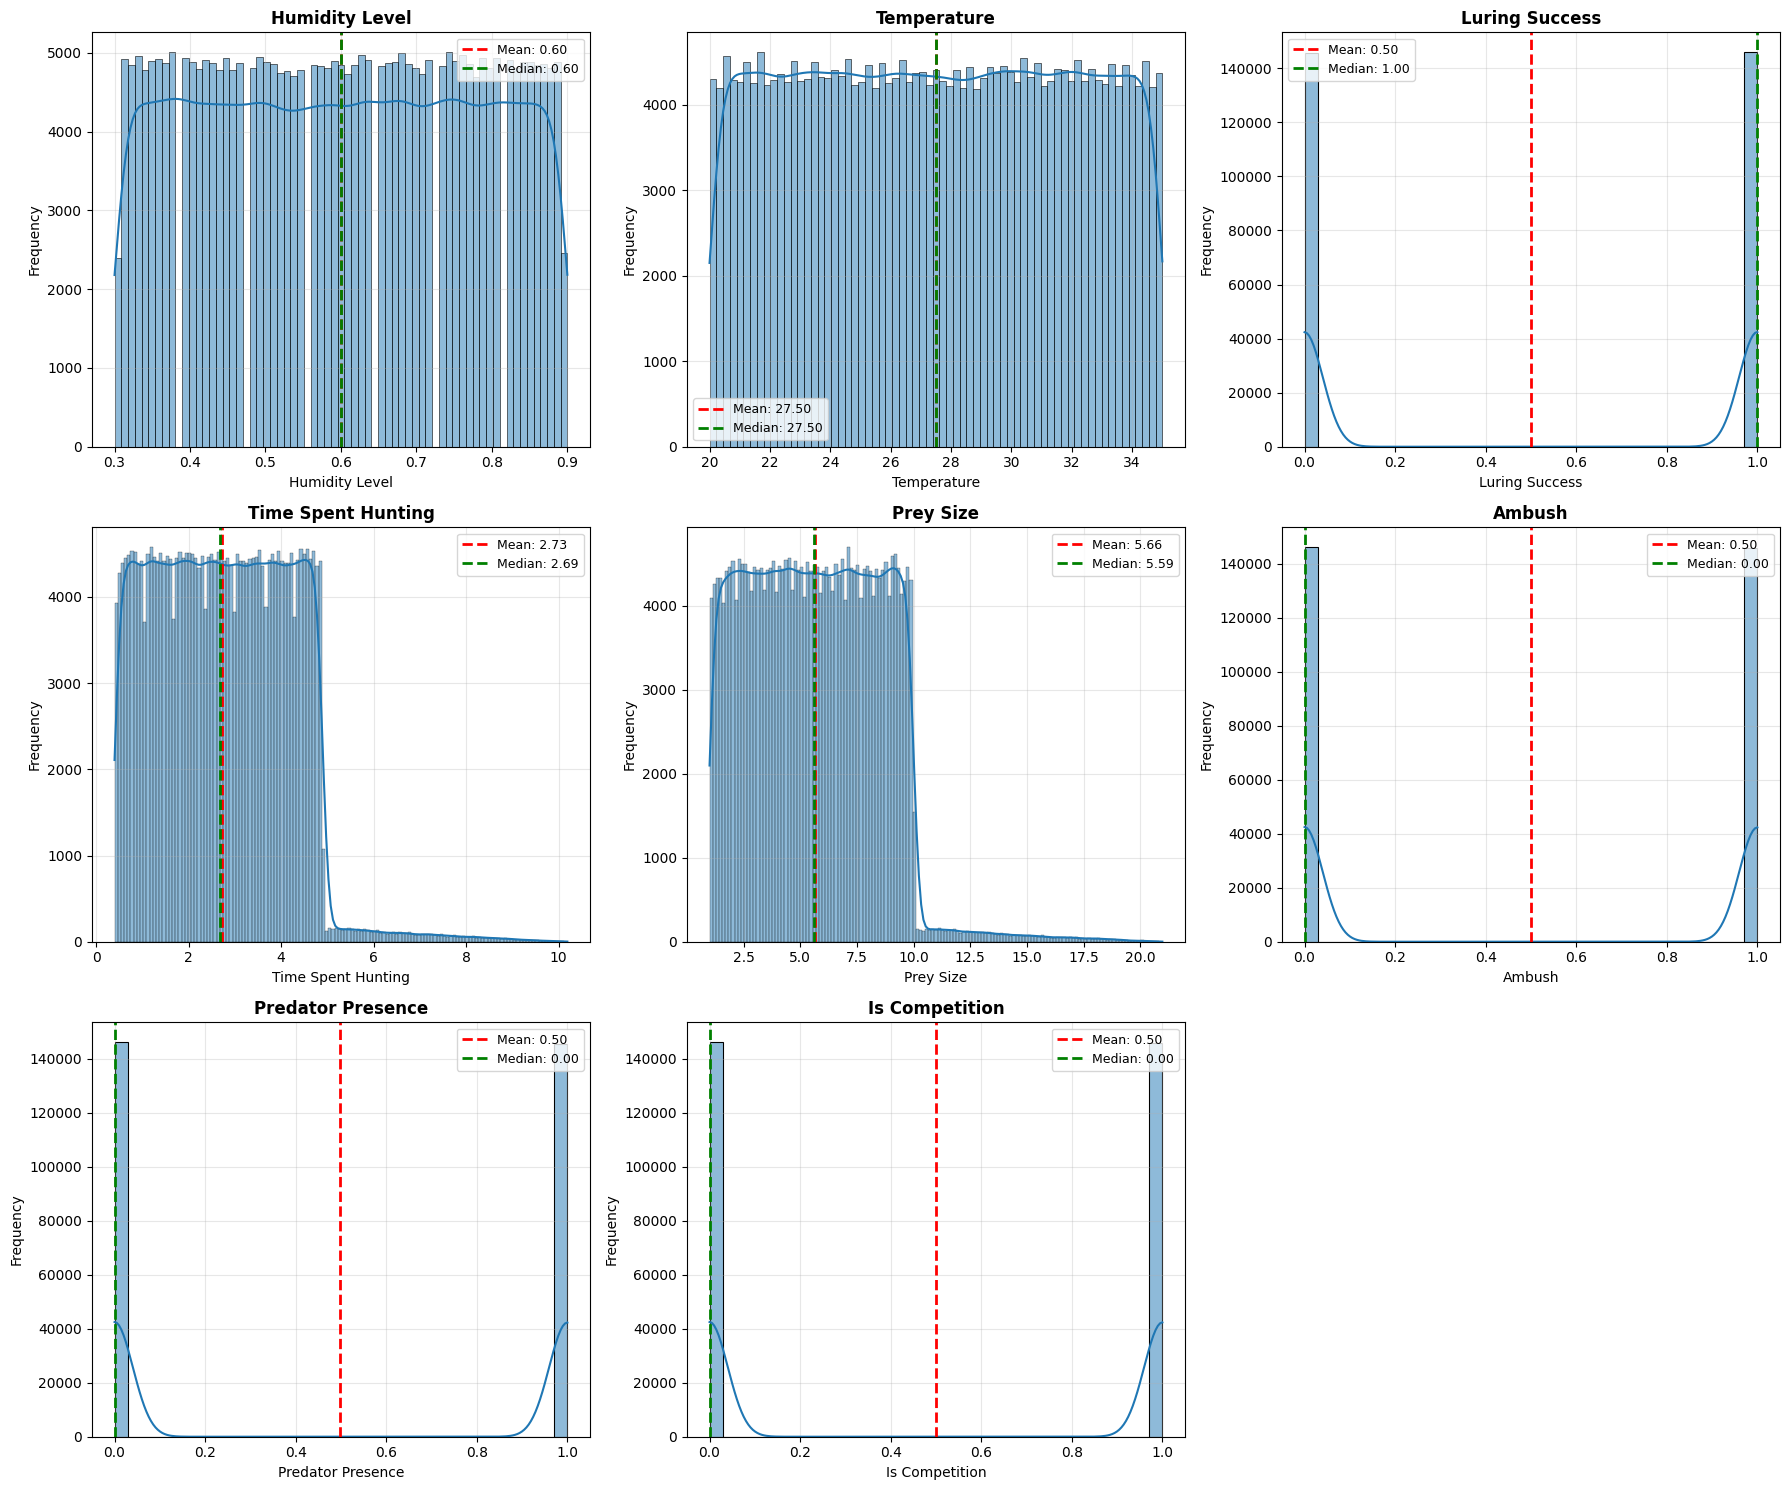

In [37]:
# Histogrami sa KDE za sve numeričke kolone
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

# Izračunavanje broja redova i kolona za grid
n_cols = 3  # Broj kolona u gridu
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Zaokruživanje naviše

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    # Histogram sa KDE
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    # Izračunavanje mean i median
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    # Dodavanje vertikalnih linija za mean i median
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

# Sakrivanje praznih subplotova
for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Boxplots


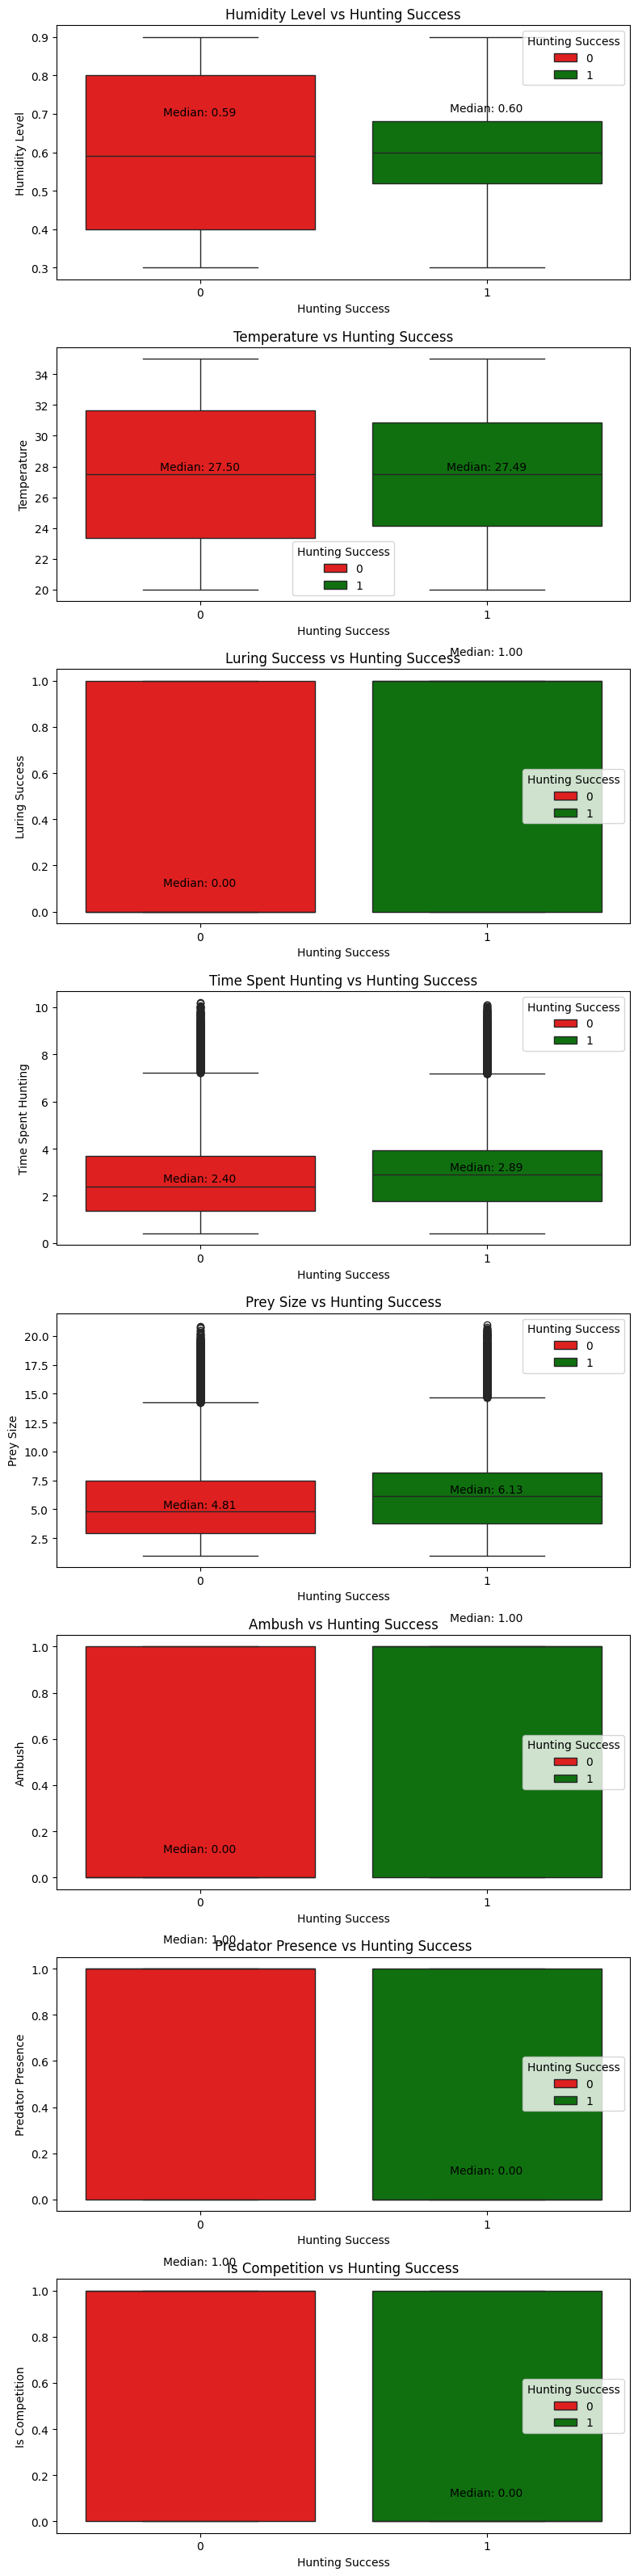

In [25]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(8, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=axes[i], palette=('red', 'green'), hue='Hunting Success')
    axes[i].set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        axes[i].text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Analiza kategorijskih kolona

In [26]:
# Identifikacija kategorijskih kolona
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


In [ ]:
# Mode (najčešća vrednost) za kategorijske kolone - tekstualni prikaz
print("Mode za kategorijske kolone:")
print("-" * 50)
for col in cat_cols:
    mode = dataset[col].mode()
    if len(mode) > 0:
        mode_value = mode.iloc[0]
        mode_count = (dataset[col] == mode_value).sum()
        mode_percentage = (mode_count / len(dataset)) * 100
        print(f"{col}:")
        print(f"  Mode: {mode_value}")
        print(f"  Frekvencija: {mode_count} ({mode_percentage:.2f}%)")
        print()


Mode za kategorijske kolone:
--------------------------------------------------
Time of Day:
  Mode: Afternoon
  Frekvencija: 97480 (33.42%)

Food Availability:
  Mode: Low
  Frekvencija: 97384 (33.39%)



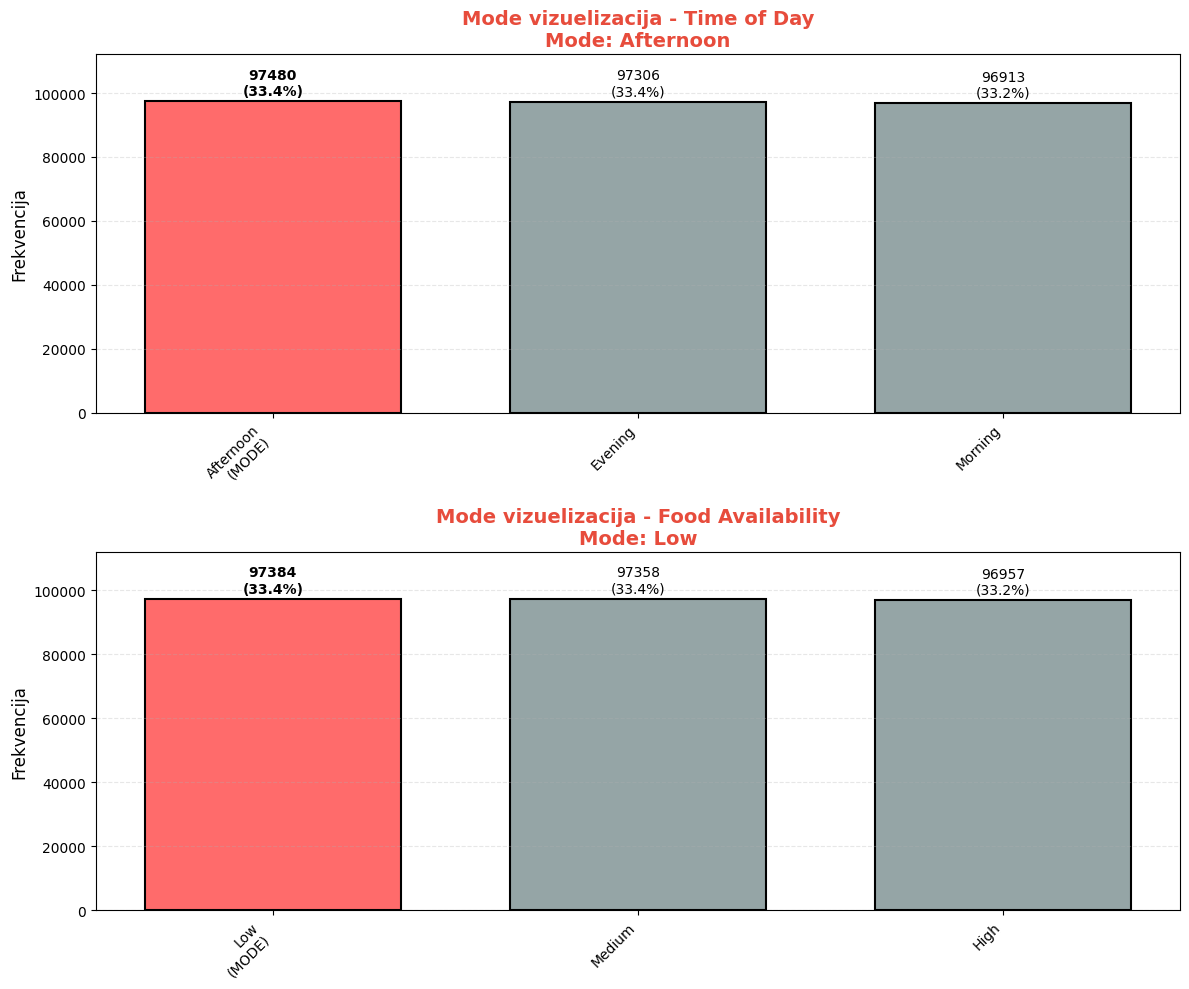

In [43]:
# Vizuelni prikaz Mode-a za kategorijske kolone
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 5 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    # Izračunavanje value counts
    value_counts = dataset[col].value_counts().sort_values(ascending=False)
    
    # Pronalaženje Mode-a
    mode_value = dataset[col].mode().iloc[0] if len(dataset[col].mode()) > 0 else None
    
    # Kreiranje liste boja - Mode bar će biti istaknut
    colors = []
    for val in value_counts.index:
        if val == mode_value:
            colors.append('#ff6b6b')  # Crvena boja za Mode
        else:
            colors.append('#95a5a6')  # Siva boja za ostale
    
    # Bar plot
    bars = axes[i].bar(range(len(value_counts)), value_counts.values, color=colors, width=0.7, edgecolor='black', linewidth=1.5)
    
    # Dodavanje vrednosti na barove
    for j, (bar, val) in enumerate(zip(bars, value_counts.values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values)*0.01,
                    f'{val}\n({val/len(dataset)*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold' if value_counts.index[j] == mode_value else 'normal')
    
    # Označavanje Mode-a na x-osi
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels([f'{label}\n(MODE)' if label == mode_value else label 
                             for label in value_counts.index], rotation=45, ha='right')
    
    axes[i].set_title(f'Mode vizuelizacija - {col}\nMode: {mode_value}', 
                      fontsize=14, fontweight='bold', color='#e74c3c')
    axes[i].set_ylabel('Frekvencija', fontsize=12)
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
    axes[i].set_ylim(0, max(value_counts.values) * 1.15)

plt.tight_layout()
plt.show()


Value counts za kategorijske kolone


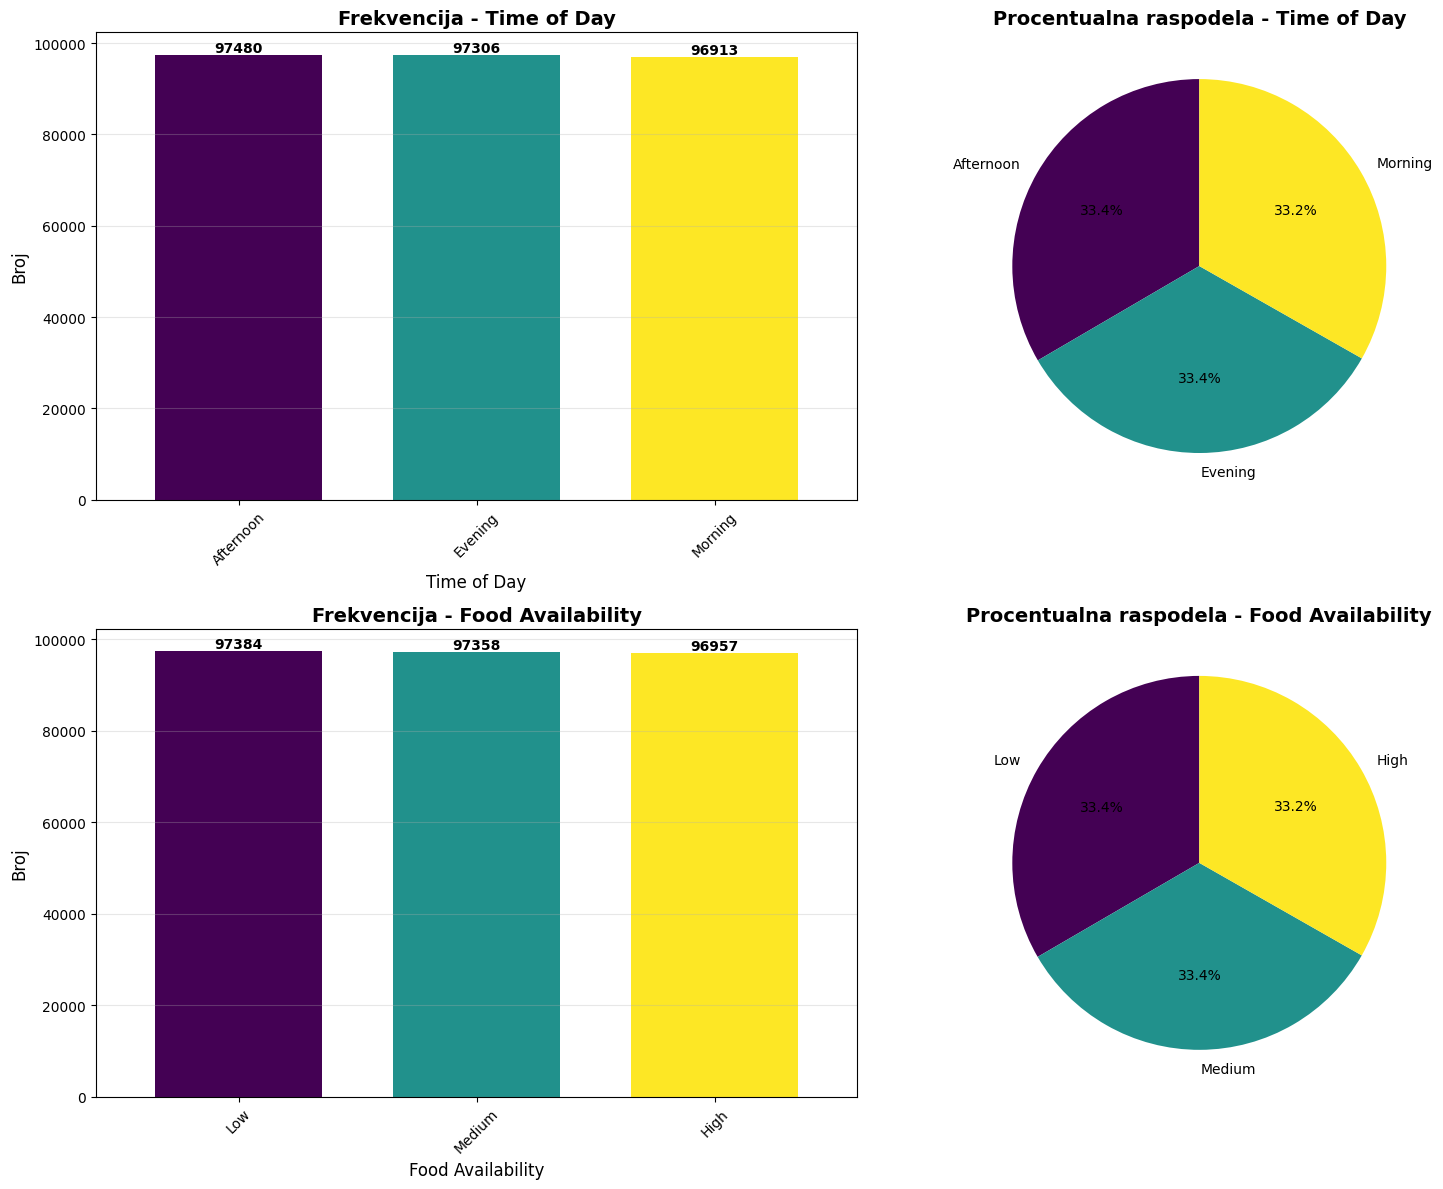

In [34]:
# Value counts sa vizuelnim prikazom za kategorijske kolone
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    # Izračunavanje value counts
    value_counts = dataset[col].value_counts()
    
    # Bar plot za frekvencije sa različitim bojama za svaki bar
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    # Dodavanje vrednosti na barove
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    # Pie chart za procentualnu raspodelu
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


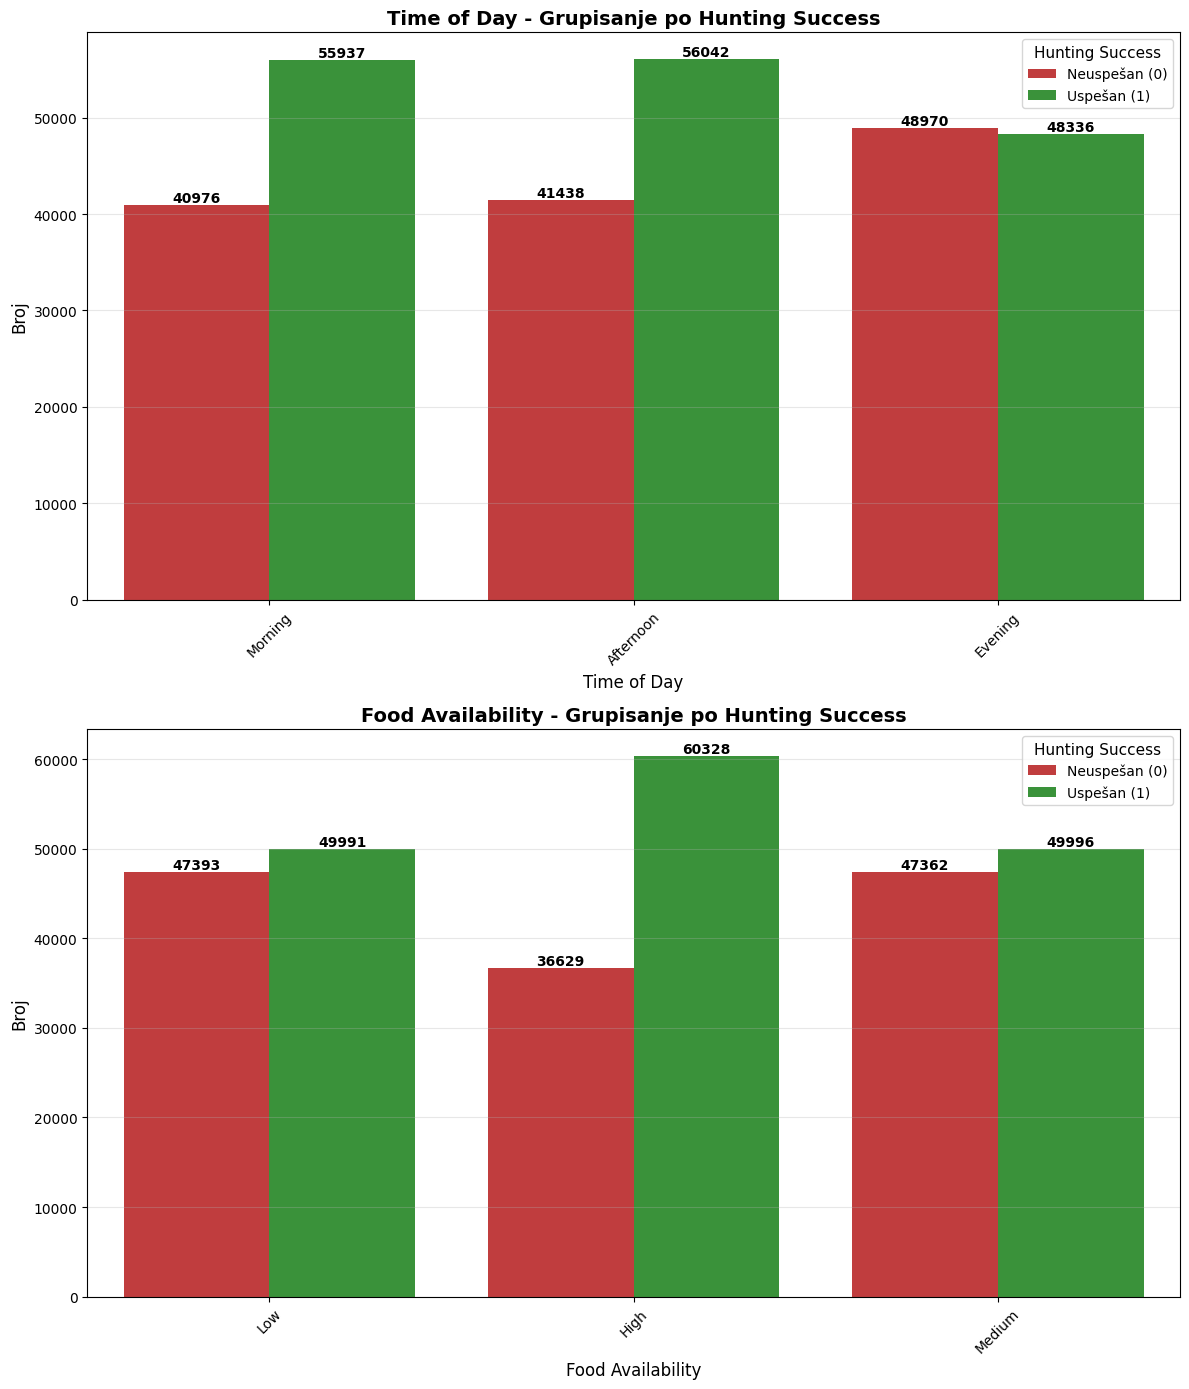

In [28]:
# Vizualizacija grupisanja po target - Grouped bar plot
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    # Count plot sa grupisanjem po target
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Dodavanje vrednosti na barove
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()
